# La Liga 2017-18 Analysis

* Is the 3 point for a win system showing us who is really the best?
* Can we get interesting hidden info about the teams that we can't by just looking at the standings?

<img src="../img/laliga.png" />

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("../data/FMEL_Dataset.csv", index_col="id")

In [3]:
data = data[(data.season == "2017-18") & (data.division == 1)]

In [4]:
data.head()

,season,division,round,localTeam,visitorTeam,localGoals,visitorGoals,date,timestamp
id,,,,,,,,,
36306,2017-18,1,1,Valencia,Las Palmas,1,0,18/08/2017,1503007200
36307,2017-18,1,1,Leganes,Alaves,1,0,18/08/2017,1503007200
36308,2017-18,1,1,Celta de Vigo,Real Sociedad,2,3,19/08/2017,1503093600
36309,2017-18,1,1,Girona,Atletico de Madrid,2,2,19/08/2017,1503093600
36310,2017-18,1,1,Sevilla,Espanol,1,1,19/08/2017,1503093600


# Model

In [5]:
import pystan as ps

In [18]:
model = """
data {
    int M;           # Number of matches
    int N;           # Number of teams
    int home[M];     # Home team
    int away[M];     # Away team
    int home_gls[M]; # Home goals
    int away_gls[M]; # Away goals
}
parameters {
    real<lower=0,upper=10> l_h_o[N];   # Team offence rates home
    real<lower=0,upper=10> l_h_d[N];   # Team defence rates home
    real<lower=0,upper=10> l_a_o[N];   # Team offence rates away
    real<lower=0,upper=10> l_a_d[N];   # Team defence rates away
}
model {
    for (n in 1:N) {
        l_h_o[N] ~ gamma(3, 1);
        l_h_d[N] ~ gamma(2, 1);
        l_a_o[N] ~ gamma(3, 1);
        l_a_d[N] ~ gamma(2, 1);
    }

    for (m in 1:M) {
        home_gls[m] ~ poisson(fmax(l_h_o[home[m]] - l_a_d[away[m]], 0.01));
        away_gls[m] ~ poisson(fmax(l_a_o[away[m]] - l_h_d[home[m]], 0.01));
    }
}
"""

In [19]:
M = len(data)
N = len(data["visitorTeam"].unique())
data["home"], home_idx = data["localTeam"].factorize()
data["away"], away_idx = data["visitorTeam"].factorize()
data["home"] += 1
data["away"] += 1
data["home_gls"] = data["localGoals"]
data["away_gls"] = data["visitorGoals"]

In [20]:
mod = ps.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8aff135342107d249de24ba168317a26 NOW.


In [21]:
samples = mod.sampling(data={
    "M": M,
    "N": N,
    "home": data["home"].values,
    "away": data["away"].values,
    "home_gls": data["home_gls"].values,
    "away_gls": data["away_gls"].values
}, iter=2000, chains=4)

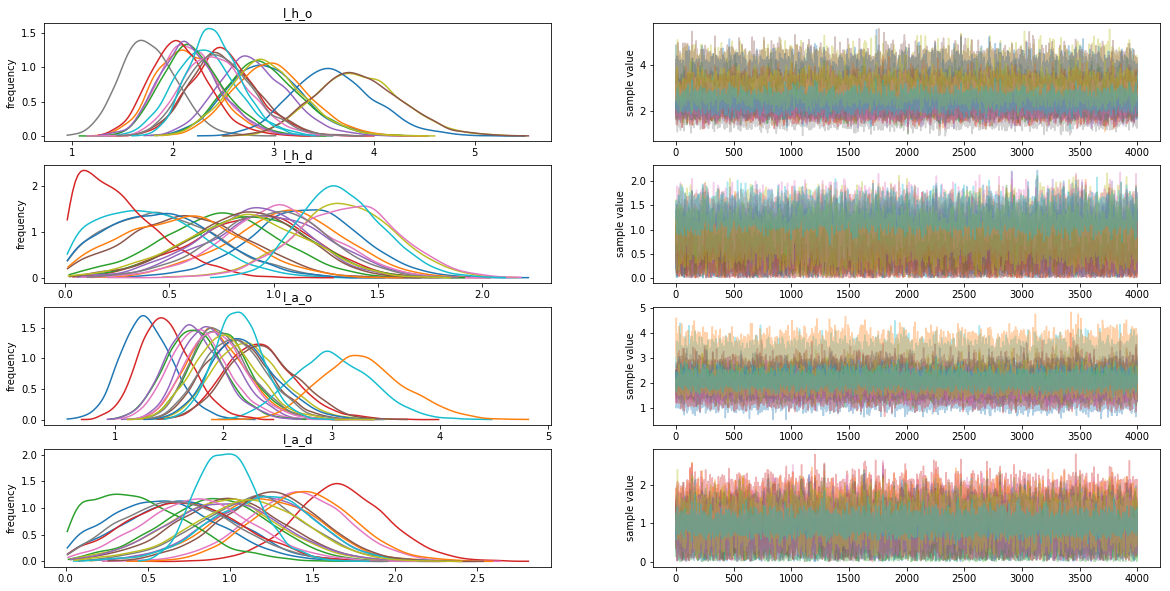

In [14]:
ax = samples.plot()
ax.set_size_inches(20, 10)

In [13]:
samples

Inference for Stan model: anon_model_9c3880a1111ea0c98a537add615bbdd9.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
l_h_o[0]    2.92    0.02   0.38   2.21   2.66    2.9   3.16   3.74    600   1.01
l_h_o[1]    2.14    0.02   0.31   1.57   1.92   2.13   2.34   2.81    412    1.0
l_h_o[2]    2.91    0.02   0.38   2.23   2.65   2.88   3.15   3.71    541    1.0
l_h_o[3]    2.51    0.01   0.33   1.91   2.28   2.49   2.71    3.2    478    1.0
l_h_o[4]     2.8    0.02   0.36   2.14   2.56   2.77   3.03   3.55    550    1.0
l_h_o[5]    2.51    0.02   0.34   1.88   2.28   2.48   2.73   3.23    441    1.0
l_h_o[6]    2.18    0.01    0.3   1.65   1.97   2.16   2.36   2.81    414    1.0
l_h_o[7]    1.77    0.01   0.28   1.25   1.57   1.75   1.95   2.36    400    1.0
l_h_o[8]    3.85    0.02   0.43   3.06   3.55   3.83   4.12   4.74    765    1.0
l

# Analysis

* Atletico has the best defence.
* Barcelona has the best offence.
* Remember Barca won.
* Real is "stronger" than Athletico!

In [11]:
# Create a Data Frame containin the results and mapping to team names
res = pd.DataFrame({
    "team": home_idx,
    "home_offence": samples["l_h_o"].mean(axis=0),
    "home_defence": samples["l_h_d"].mean(axis=0)
}).merge(pd.DataFrame({
    "team": away_idx,
    "away_offence": samples["l_a_o"].mean(axis=0),
    "away_defence": samples["l_a_d"].mean(axis=0)
}))
res["offence"] = res[['home_offence', 'away_offence']].mean(axis=1)
res["defence"] = res[['home_defence', 'away_defence']].mean(axis=1)

In [17]:
res.sort_values(by="offence", ascending=False)

,team,home_offence,home_defence,away_offence,away_defence,offence,defence
8,Barcelona,3.848695,1.334859,3.290517,1.448130,3.569606,1.391495
15,Real Madrid,3.839694,0.855718,3.010028,1.191505,3.424861,1.023612
10,Real Sociedad,3.595964,0.477393,1.982978,0.907897,2.789471,0.692645
0,Valencia,2.918695,1.149433,2.365788,1.244639,2.642242,1.197036
11,Betis,2.979970,0.568327,2.233720,0.952015,2.606845,0.760171
2,Celta de Vigo,2.905564,0.742074,2.196661,0.611622,2.551113,0.676848
18,Villarreal,2.930643,0.857388,2.134300,0.991657,2.532471,0.924523
19,Atletico de Madrid,2.418949,1.328112,2.343823,1.672976,2.381386,1.500544
4,Sevilla,2.798265,0.975348,1.938078,0.813148,2.368172,0.894248
3,Girona,2.506366,0.895274,2.142393,0.987683,2.324380,0.941479
